# Введение в анализ данных

# Семинар 9.

## Свойства деревьев решений

**Задача 1.** Пусть решается задача регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и решающее дерево с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?

**Решение.**
Поскольку истинная зависимость в данных является линейной, логично предположить, что линейная модель покажет лучшие результаты на подобной выборке. Опишем формально ситуацию, в которой у решающего дерева могут возникнуть серьезные проблемы с восстановлением истинной зависимости.

Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

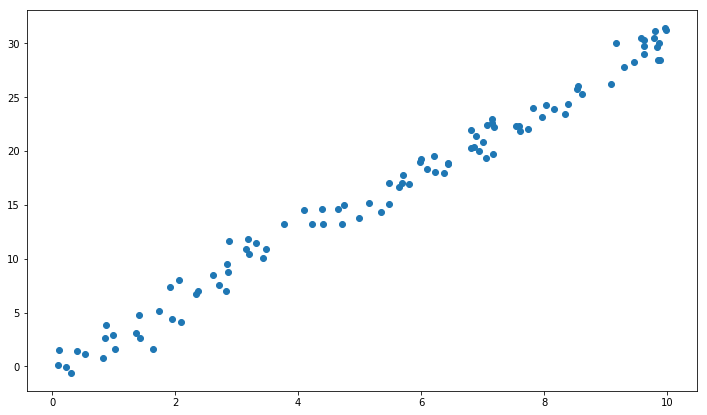

In [10]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, Y_train)
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

LR train MSE =  1.332100321623538
DT train MSE =  0.0


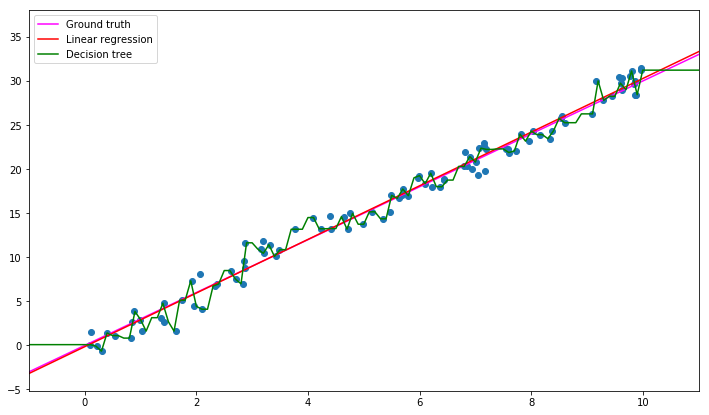

In [12]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print ('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

LR test MSE =  2.2359778042509886
DT test MSE =  2043.5991471616032


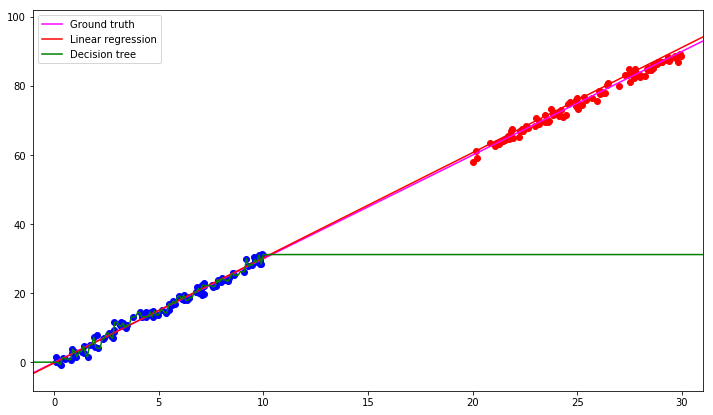

In [13]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

**Вывод**: решающие деревья (а потому и композиции над ними) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).

**Задача 2.** Приведите временную асимптотику обучения и построения прогнозов для композиции вида $a_N(x) = \sum_{n=0}^N b_n(x)$ над решающими деревьями $b_n$.

**Решение.**
На стадии обучения при построении очередного решающего дерева глубины $D$ (под глубиной решающего дерева понимается максимальное количество ребер на кратчайшем пути от корня дерева до листа) нам необходимо выбрать предикаты в не более чем $2^D - 1$ внутренних вершинах этого дерева. Каждый порог выбирается путем перебора $\le l - 1$ значений  для каждого из $d$ признаков. После выбора предиктов необходимо вычислить прогноз дерева в каждом из листов за линейное время от количества объектов обучающей выборки, попавших в лист. Для вычисления прогнозов во всех листах одновременно нам достаточно один раз пройтись по всем объектам. Отсюда асимптотика построения одного решающего дерева — $O(2^D l d + l) = O(2^D l d).$

На стадии построения прогноза для объекта $x$ он "пропускается" через дерево от корня к листьям, тем самым проходя путь из не более чем $D$ внутренних вершин, в каждой из которых происходит проверка предиката за константное время. Отсюда имеем асимптотику для построения прогноза композиции — $O(ND)$.

## Бэггинг и случайный лес

Теперь обсудим композиции алгоритмов.

Посмотрим на поведение бэггинга и случайного леса с ростом числа базовых алгоритмов.

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же случайного леса мы не только усредняем алгоритмы, но и случайным образом выбираем множество признаков, на котором каждое из них строится.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

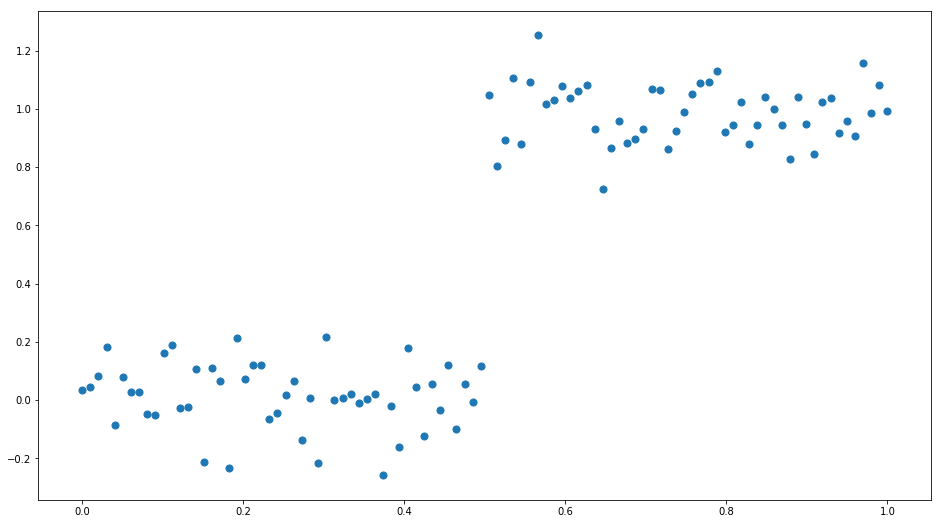

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

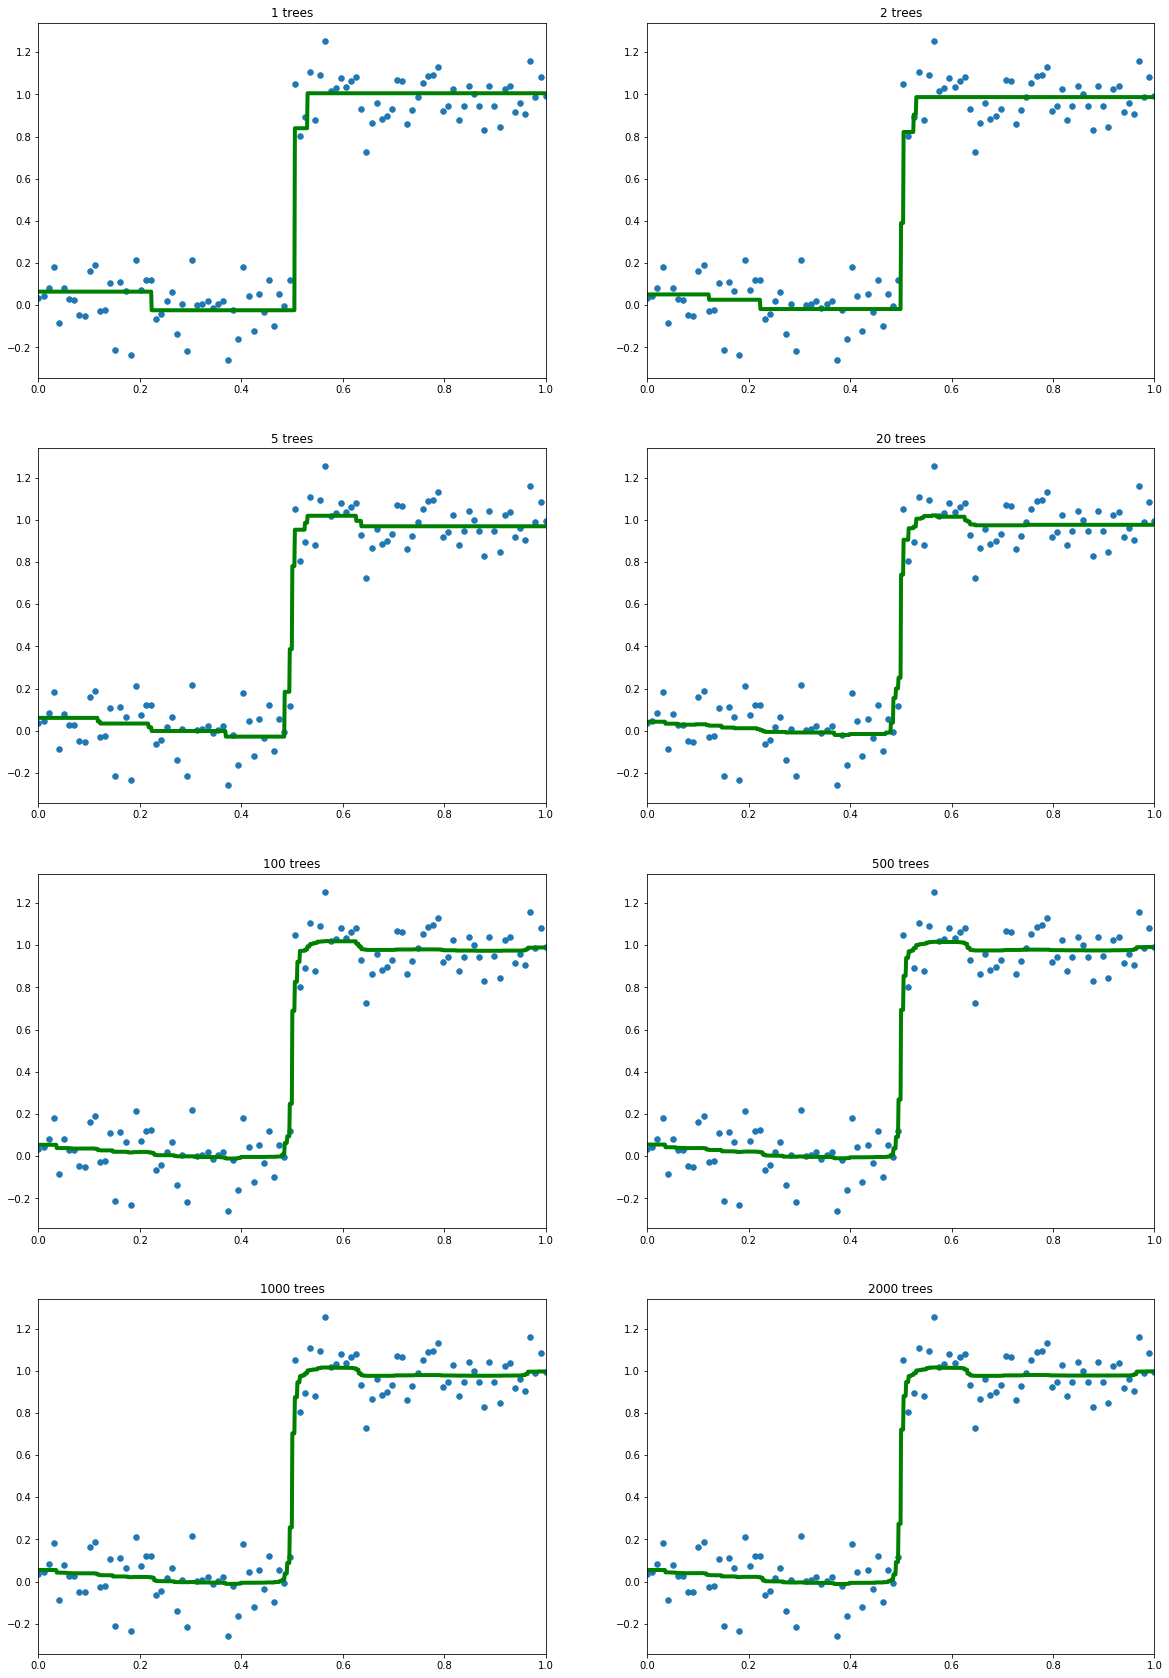

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для случайного леса.

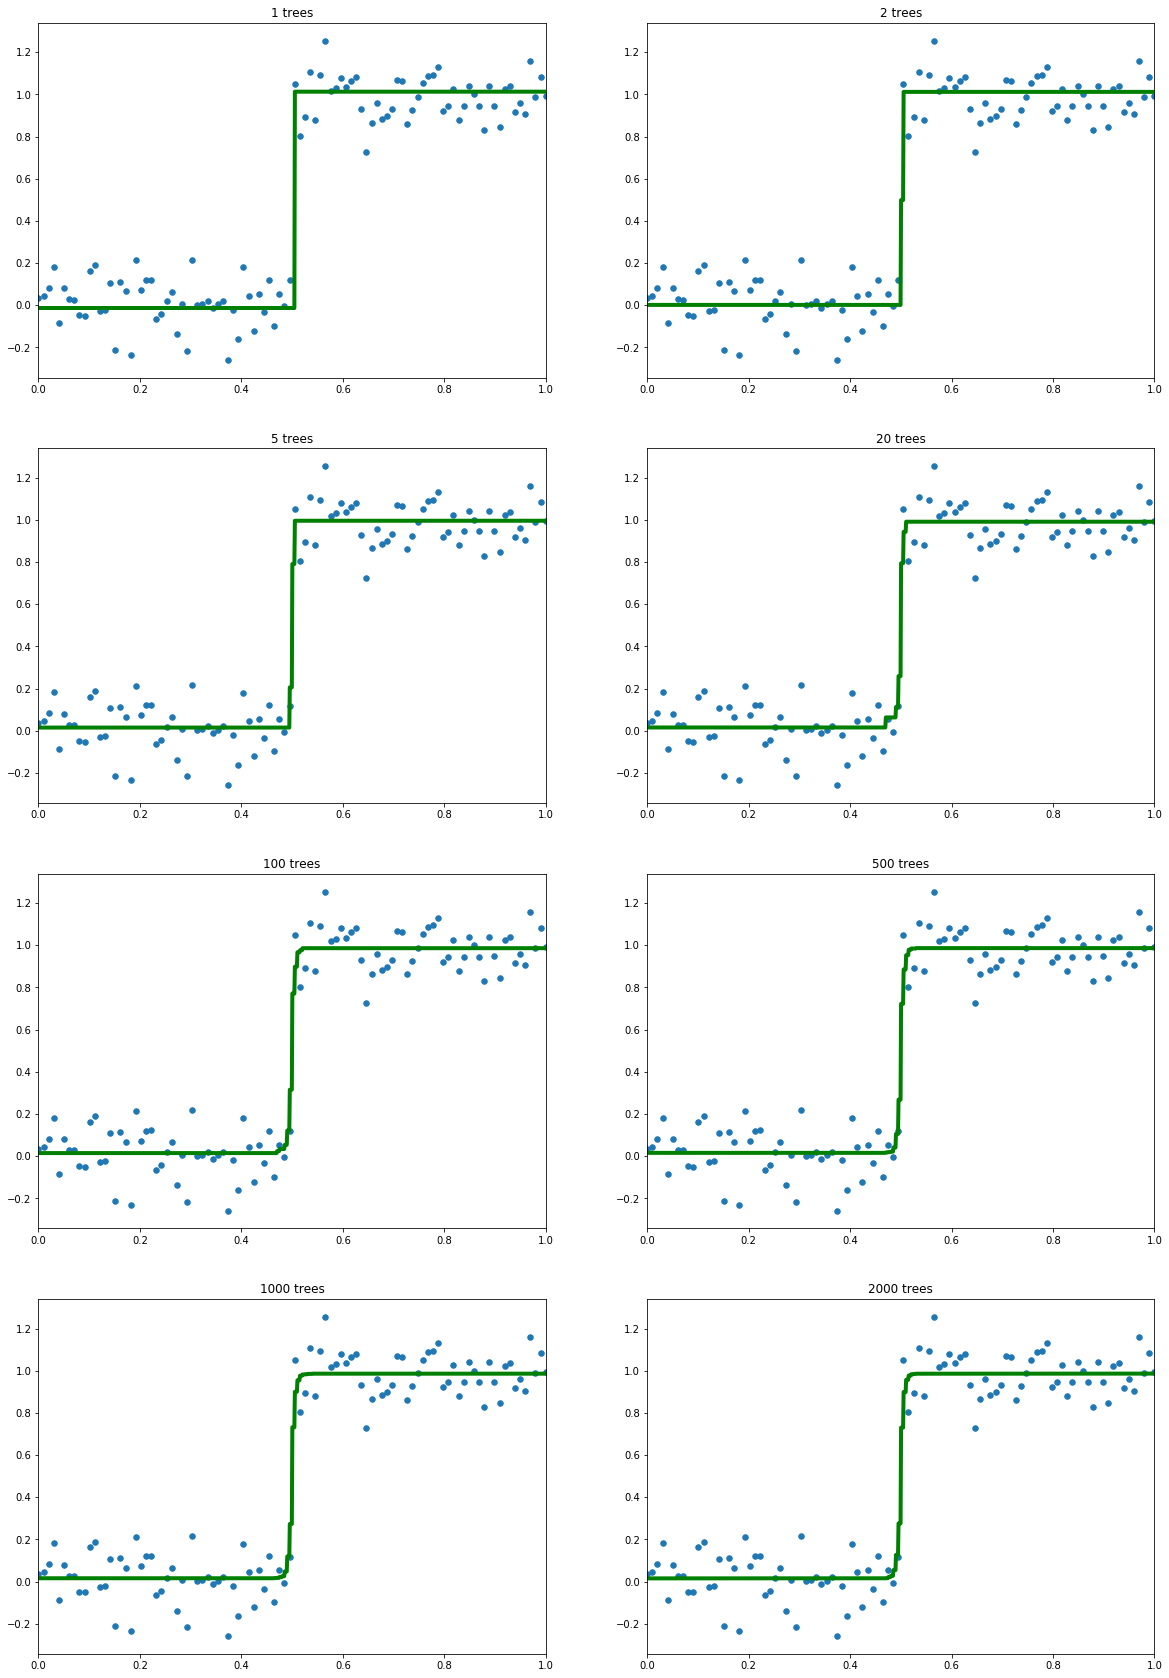

In [5]:
reg = RandomForestRegressor(max_depth=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))